In [ ]:
!pip install torch_geometric

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import torch_geometric
import torch.nn.functional as F
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load in Data and Run Dependencies

In [ ]:
%run "/content/drive/MyDrive/Colab Notebooks/NEURO_final/pytorch_geometric_temporal/torch_geometric_temporal/nn/recurrent/temporalgcn.py"
%run "/content/drive/MyDrive/Colab Notebooks/NEURO_final/pytorch_geometric_temporal/torch_geometric_temporal/nn/recurrent/attentiontemporalgcn.py"
%run "/content/drive/MyDrive/Colab Notebooks/NEURO_final/pytorch_geometric_temporal/torch_geometric_temporal/dataset/metr_la.py"

<Figure size 640x480 with 0 Axes>

In [ ]:
sensor_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NEURO_final/data/METR-LA.csv')
adj = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/NEURO_final/data/adj_mx_METR-LA.pkl')
tmp = sensor_df.copy()

In [ ]:
# Reshape data for loading
tmp = np.array(tmp)
tmp = tmp.reshape(tmp.shape[0], 1, tmp.shape[1])
node_values = tmp[:, :, 1:]

column_mapping = adj[1]
adj_mat = adj[2]

adj_df = pd.DataFrame(data=adj_mat)

adj_df.columns = [key for key, _ in sorted(column_mapping.items(), key=lambda x: x[1])]
adj_df.index = adj_df.columns

In [ ]:
# CODE FROM PYTORCH-GEOMETRIC-TEMPORAL CODEBASE

def temporal_signal_split(data_iterator, train_ratio: float = 0.7):

    train_snapshots = int(train_ratio * data_iterator.snapshot_count)

    train_iterator = data_iterator[0:train_snapshots]
    test_iterator = data_iterator[train_snapshots:]

    return train_iterator, test_iterator

In [ ]:
loader = METRLADatasetLoader(adj_df, node_values)
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

train_data, test_data = temporal_signal_split(dataset)

(1, 207, 34272)


# Visualization of Observations across Time

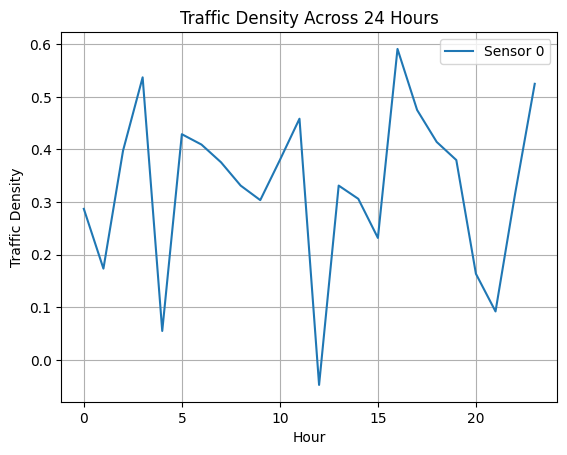

In [ ]:
sensor_number = 0
hours = 24
sensor_labels = [ex.y[sensor_number][0].item() for ex in list(dataset)[:hours]]
plt.plot(sensor_labels, label='Sensor {}'.format(sensor_number))
plt.title('Traffic Density Across 24 Hours')
plt.xlabel('Hour')
plt.ylabel('Traffic Density')
plt.grid()
plt.legend()
plt.show()

In [ ]:
batch_size=32
if torch.cuda.is_available():
    device = 'cuda'
else:
  device = 'cpu'

In [ ]:
train_input = np.array(train_data.features)
train_target = np.array(train_data.targets)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(device)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(device)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=True,drop_last=True)

In [ ]:
test_input = np.array(test_data.features)
test_target = np.array(test_data.targets)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(device)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(device)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=True,drop_last=True)

#Baseline Model - RNN

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class BaselineRNN(torch.nn.Module):
    def __init__(self, input_size=12, hidden_size=64, num_layers=5, output_size=12):
      super(BaselineRNN, self).__init__()
      # Define recurrent layers
      self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

      # Define fully connected layer
      self.fc = nn.Linear(hidden_size, output_size)

      # Define activation function
      self.relu = nn.ReLU()

    def forward(self, x):
      x = x.squeeze(2)
      out, _ = self.rnn(x)
      out = self.fc(out)
      return out


BaselineRNN()

BaselineRNN(
  (rnn): RNN(12, 64, num_layers=5, batch_first=True)
  (fc): Linear(in_features=64, out_features=12, bias=True)
  (relu): ReLU()
)

In [ ]:
model = BaselineRNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
model.to(device)
lowest_mse = float('inf')
model.train()
train_losses = []

for epoch in range(5):
    step = 0
    loss_list = []
    for inputs, labels in train_loader:
        y_hat = model(inputs)
        loss = loss_fn(y_hat, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step = step+ 1
        loss_list.append(loss.item())

    train_losses.append(sum(loss_list)/len(loss_list))
    print("Epoch {} train MSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))


Epoch 0 train MSE: 0.3409
Epoch 1 train MSE: 0.3115
Epoch 2 train MSE: 0.3261
Epoch 3 train MSE: 0.3487
Epoch 4 train MSE: 0.3216


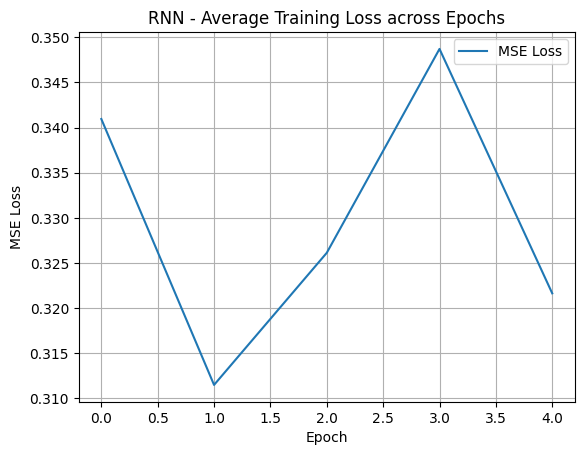

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(train_losses, label='MSE Loss')
plt.title('RNN - Average Training Loss across Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
sensor = 100
timestep = 11
hat = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
true  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])

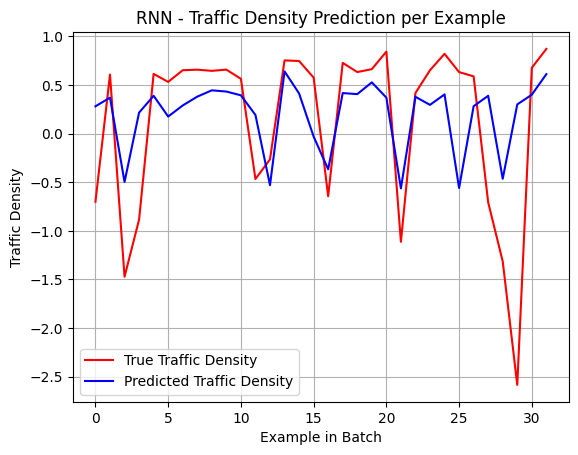

In [ ]:
plt.plot(true, label='True Traffic Density', color='r')
plt.plot(hat, label='Predicted Traffic Density', color='b')
plt.title('RNN - Traffic Density Prediction per Example')
plt.xlabel('Example in Batch')
plt.ylabel('Traffic Density')
plt.legend()
plt.grid()
plt.show()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
model.to(device)
lowest_mse = float('inf')

model.eval()
test_losses = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        y_hat = model(inputs)
        loss = loss_fn(y_hat, labels)
        test_losses.append(loss.item())

print("Test MSE: {}".format(sum(test_losses) / len(test_losses)))


Test MSE: 0.392864012643927


In [ ]:
sensor = 100
timestep = 11
hat = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
true  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])

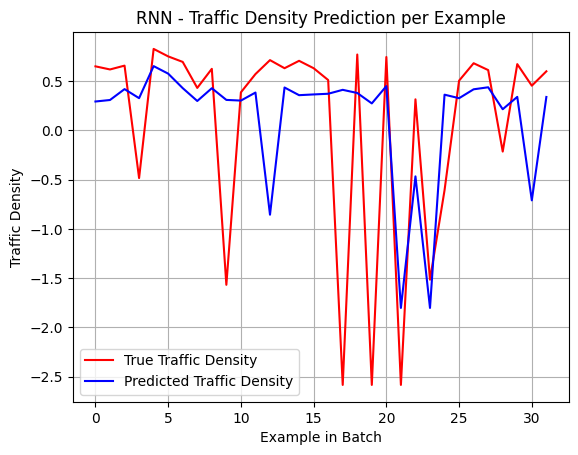

In [ ]:
plt.plot(true, label='True Traffic Density', color='r')
plt.plot(hat, label='Predicted Traffic Density', color='b')
plt.title('RNN - Traffic Density Prediction per Example')
plt.xlabel('Example in Batch')
plt.ylabel('Traffic Density')
plt.legend()
plt.grid()
plt.show()

In [ ]:
sensor = 100
hat = np.asarray([pred[sensor].detach().cpu().numpy() for pred in y_hat])
true  = np.asarray([label[sensor].cpu().numpy() for label in labels])

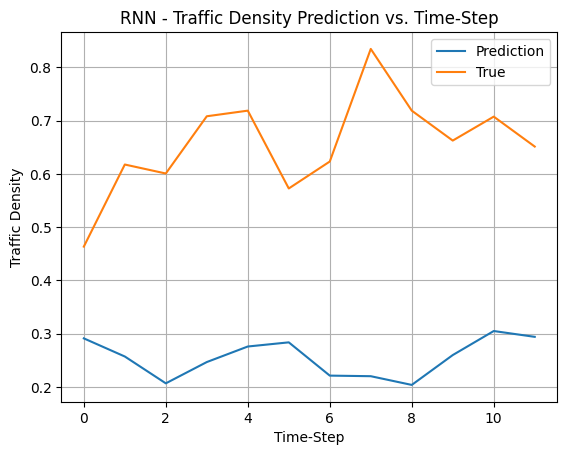

In [ ]:
plt.plot(hat[0], label='Prediction')
plt.plot(true[0], label='True')
plt.title('RNN - Traffic Density Prediction vs. Time-Step')
plt.xlabel('Time-Step')
plt.ylabel('Traffic Density')
plt.grid()
plt.legend()
plt.show()

#Baseline Model - CNN

In [ ]:
from torch import nn

In [ ]:
class BaselineCNN(torch.nn.Module):
    def __init__(self, input_channels=207, num_locations=207, num_timesteps=12, num_features=1):
      super(BaselineCNN, self).__init__()
      # Define the convolutional layers
      self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, stride=1, padding=1)
      self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
      self.conv3 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
      self.conv4 = nn.Conv1d(64, 207, kernel_size=3, stride=1, padding=1)


      # Define the fully connected layers
      self.fc1 = nn.Linear(12, 12)

      # Define activation function
      self.relu = nn.ReLU()

    def forward(self, x):

      # Collapse
      x = x.squeeze(2)

      x = self.relu(self.conv1(x))
      x = self.relu(self.conv2(x))
      x = self.relu(self.conv3(x))
      x = self.relu(self.conv4(x))

      x = self.relu(self.fc1(x))

      return x

BaselineCNN()

BaselineCNN(
  (conv1): Conv1d(207, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(64, 207, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=12, out_features=12, bias=True)
  (relu): ReLU()
)

In [ ]:
model = BaselineCNN()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
model.to(device)
lowest_mse = float('inf')
model.train()
train_losses = []

for epoch in range(5):
    step = 0
    loss_list = []
    for inputs, labels in train_loader:
        y_hat = model(inputs)
        loss = loss_fn(y_hat, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step = step+ 1
        loss_list.append(loss.item())

    train_losses.append(sum(loss_list)/len(loss_list))
    print("Epoch {} train MSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

Epoch 0 train MSE: 0.8704
Epoch 1 train MSE: 0.8875
Epoch 2 train MSE: 0.9203
Epoch 3 train MSE: 0.9209
Epoch 4 train MSE: 0.9210


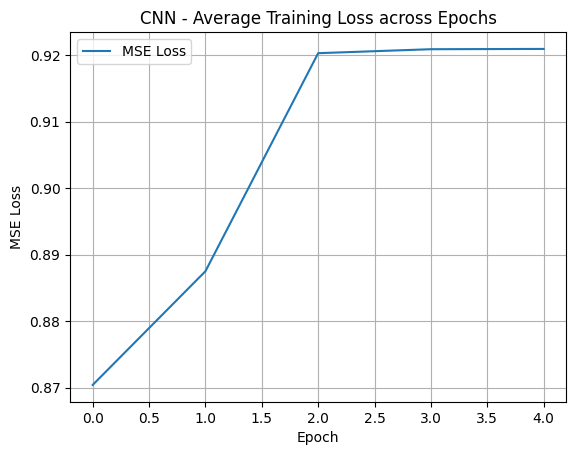

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(train_losses, label='MSE Loss')
plt.title('CNN - Average Training Loss across Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
sensor = 100
timestep = 11
hat = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
true  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])

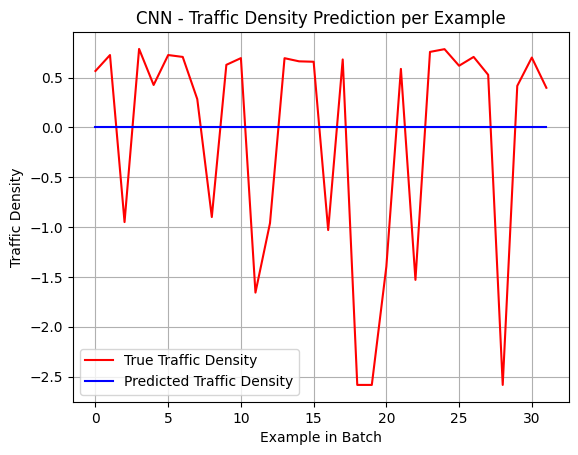

In [ ]:
plt.plot(true, label='True Traffic Density', color='r')
plt.plot(hat, label='Predicted Traffic Density', color='b')
plt.title('CNN - Traffic Density Prediction per Example')
plt.xlabel('Example in Batch')
plt.ylabel('Traffic Density')
plt.legend()
plt.grid()
plt.show()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
model.to(device)
lowest_mse = float('inf')

model.eval()
test_losses = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        y_hat = model(inputs)
        loss = loss_fn(y_hat, labels)
        test_losses.append(loss.item())

print("Test MSE: {}".format(sum(test_losses) / len(test_losses)))


Test MSE: 1.184833550935965


In [ ]:
sensor = 100
timestep = 11
hat = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
true  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])

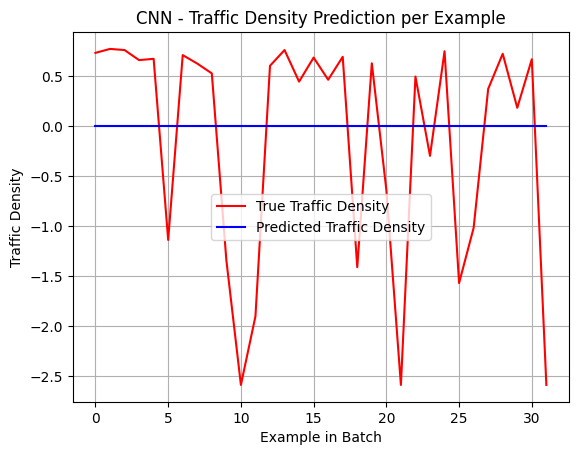

In [ ]:
plt.plot(true, label='True Traffic Density', color='r')
plt.plot(hat, label='Predicted Traffic Density', color='b')
plt.title('CNN - Traffic Density Prediction per Example')
plt.xlabel('Example in Batch')
plt.ylabel('Traffic Density')
plt.legend()
plt.grid()
plt.show()

#Custom GNN

In [ ]:

class CustomGNN(torch.nn.Module):
    def __init__(self, input_size=12, hidden_size=12, output_size=12, num_layers=3, input_channels=12):
      super(CustomGNN, self).__init__()

      self.num_layers = num_layers
      self.hidden_size = hidden_size

      # Temporal component (GRU)
      self.temporal_block = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

      # Spatial component (GCN)
      self.spatial_block = GCNConv(input_channels, hidden_size)

      # Attention mechanism
      self.attention = nn.Sequential(
          nn.Linear(hidden_size, 1),
          nn.Tanh()
      )

      self.fc1 = nn.Linear(hidden_size, output_size)
      self.fc2 = nn.Linear(hidden_size, output_size)

      self.sigmoid = nn.Sigmoid()
      self.relu = nn.ReLU()

    def forward(self, x, edge_index):
      x = x.squeeze(2)

      # Temporal block (GRU)
      x_temporal, _ = self.temporal_block(x)

      # Spatial block (GCN)
      x_spatial = self.spatial_block(x, edge_index)
      x_spatial = self.relu(x_spatial)

      # Attention mechanism
      alpha = self.attention(x_temporal)
      alpha = torch.transpose(alpha, 1, 2)
      alpha = F.softmax(alpha, dim=1)
      context_vector = torch.matmul(alpha, x_temporal)

      # Combine temporal and spatial information
      combined_features = x_spatial + context_vector

      # Final fully connected layers
      output1 = self.fc1(combined_features)
      output2 = self.fc2(combined_features)

      # Gate mechanism
      u = self.sigmoid(output1)
      r = self.sigmoid(output2)
      c = torch.tanh(output2)

      # Update hidden states
      h = u * x_temporal + (1 - u) * c

      return h

In [ ]:
model = CustomGNN()

In [ ]:
for el in train_data:
    edge_index = el.edge_index.to(device)
    break;

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
model.to(device)
lowest_mse = float('inf')
model.train()
train_losses = []

for epoch in range(5):
    step = 0
    loss_list = []
    for inputs, labels in train_loader:
        y_hat = model(inputs, edge_index)
        loss = loss_fn(y_hat, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step = step+ 1
        loss_list.append(loss.item())

    train_losses.append(sum(loss_list)/len(loss_list))
    print("Epoch {} train MSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

Epoch 0 train MSE: 0.5681
Epoch 1 train MSE: 0.5308
Epoch 2 train MSE: 0.5452
Epoch 3 train MSE: 0.5023
Epoch 4 train MSE: 0.4933


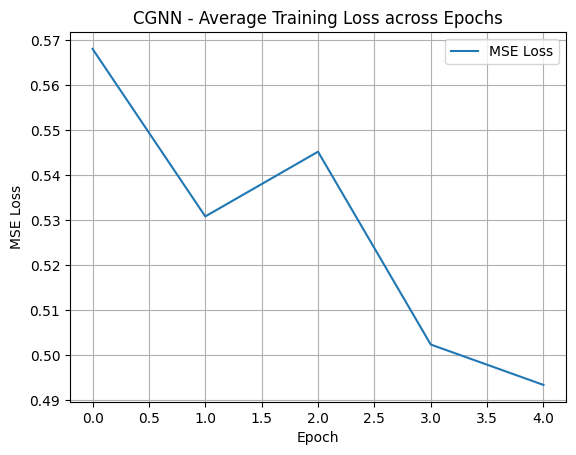

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(train_losses, label='MSE Loss')
plt.title('CGNN - Average Training Loss across Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
sensor = 100
timestep = 11
hat = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
true  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])

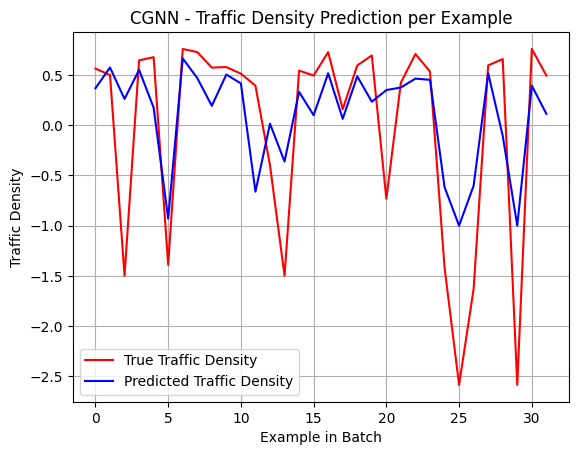

In [ ]:
plt.plot(true, label='True Traffic Density', color='r')
plt.plot(hat, label='Predicted Traffic Density', color='b')
plt.title('CGNN - Traffic Density Prediction per Example')
plt.xlabel('Example in Batch')
plt.ylabel('Traffic Density')
plt.legend()
plt.grid()
plt.show()

#Validation

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
model.to(device)
lowest_mse = float('inf')

model.eval()
test_losses = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        y_hat = model(inputs, edge_index)
        loss = loss_fn(y_hat, labels)
        test_losses.append(loss.item())

print("Test MSE: {}".format(sum(test_losses) / len(test_losses)))


Test MSE: 0.6319555975380716


In [ ]:
sensor = 100
timestep = 11
hat = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
true  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])

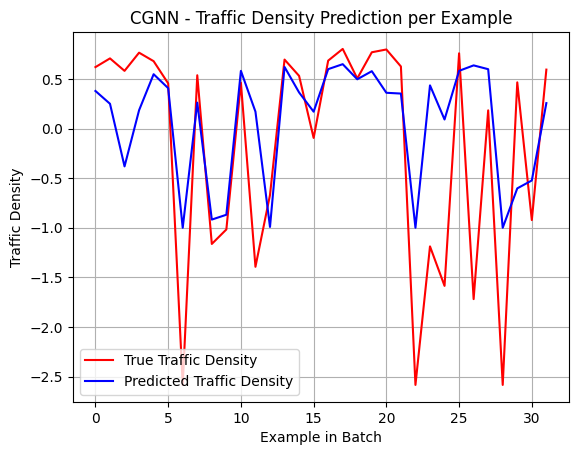

In [ ]:
plt.plot(true, label='True Traffic Density', color='r')
plt.plot(hat, label='Predicted Traffic Density', color='b')
plt.title('CGNN - Traffic Density Prediction per Example')
plt.xlabel('Example in Batch')
plt.ylabel('Traffic Density')
plt.legend()
plt.grid()
plt.show()

In [ ]:
sensor = 100
hat = np.asarray([pred[sensor].detach().cpu().numpy() for pred in y_hat])
true  = np.asarray([label[sensor].cpu().numpy() for label in labels])

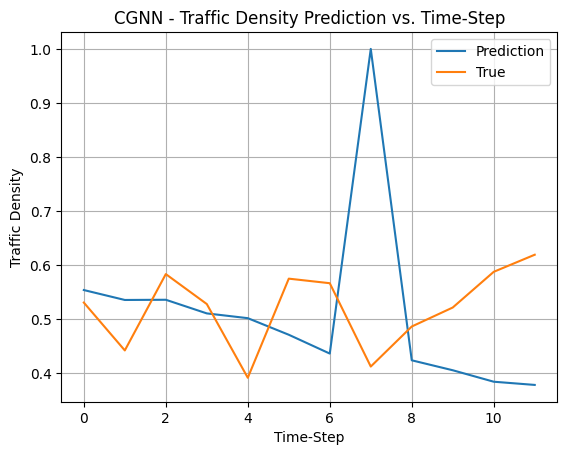

In [ ]:
plt.plot(hat[0], label='Prediction')
plt.plot(true[0], label='True')
plt.title('CGNN - Traffic Density Prediction vs. Time-Step')
plt.xlabel('Time-Step')
plt.ylabel('Traffic Density')
plt.grid()
plt.legend()
plt.show()

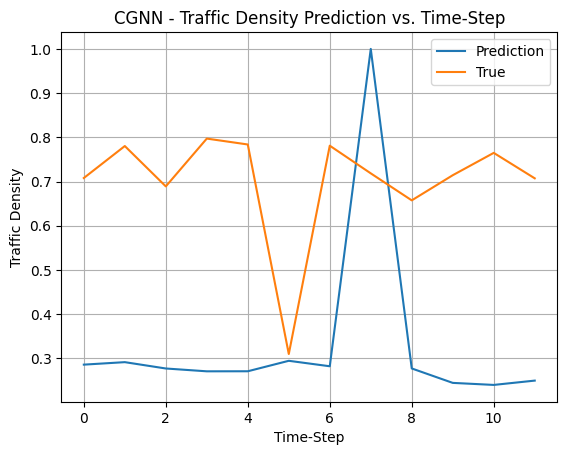

In [ ]:
plt.plot(hat[1], label='Prediction')
plt.plot(true[1], label='True')
plt.title('CGNN - Traffic Density Prediction vs. Time-Step')
plt.xlabel('Time-Step')
plt.ylabel('Traffic Density')
plt.grid()
plt.legend()
plt.show()

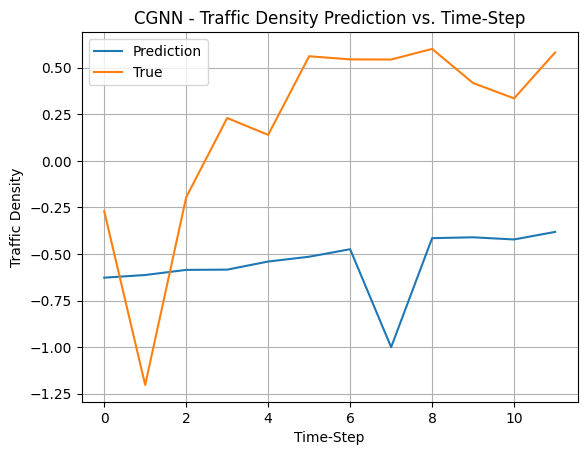

In [ ]:
plt.plot(hat[2], label='Prediction')
plt.plot(true[2], label='True')
plt.title('CGNN - Traffic Density Prediction vs. Time-Step')
plt.xlabel('Time-Step')
plt.ylabel('Traffic Density')
plt.grid()
plt.legend()
plt.show()

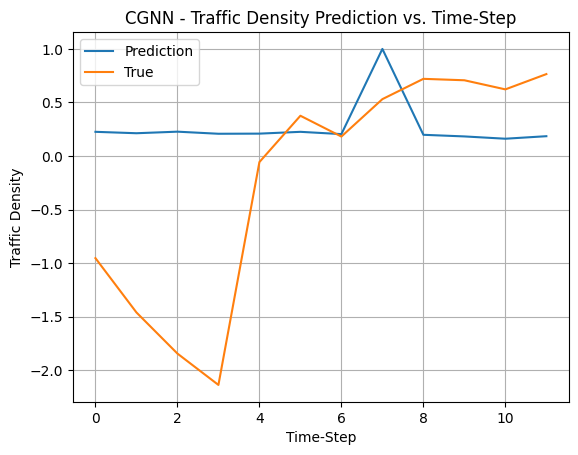

In [ ]:
plt.plot(hat[3], label='Prediction')
plt.plot(true[3], label='True')
plt.title('CGNN - Traffic Density Prediction vs. Time-Step')
plt.xlabel('Time-Step')
plt.ylabel('Traffic Density')
plt.grid()
plt.legend()
plt.show()

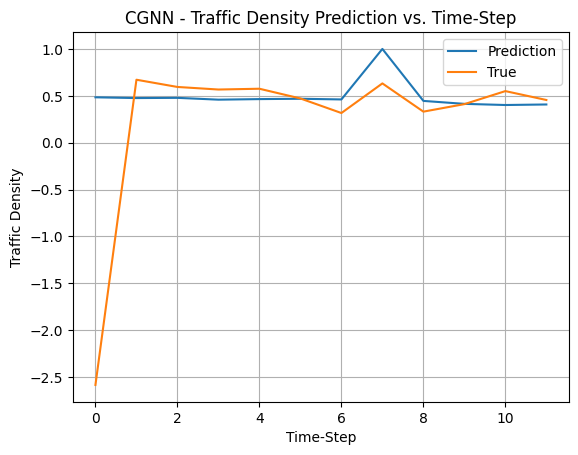

In [ ]:
plt.plot(hat[5], label='Prediction')
plt.plot(true[5], label='True')
plt.title('CGNN - Traffic Density Prediction vs. Time-Step')
plt.xlabel('Time-Step')
plt.ylabel('Traffic Density')
plt.grid()
plt.legend()
plt.show()

# Graph Neural Network Architecture

In [ ]:
#CODE FROM PYTORCH-GEOMETRIC-TEMPORAL
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn1 = A3TGCN2(in_channels=node_features,
                           out_channels=32,
                           periods=periods,
                            batch_size=batch_size)
        #OUTPUT SHAPE (32x207x32)
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn1(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=1, periods=12, batch_size=32)

TemporalGNN(
  (tgnn1): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(1, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(1, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(1, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [ ]:
model = TemporalGNN(node_features=1, periods=12, batch_size=32)

# Training Loop

In [ ]:
for el in train_data:
    edge_index = el.edge_index.to(device)
    break;

In [ ]:
print(edge_index.shape)

torch.Size([2, 1722])


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
model.to(device)
lowest_mse = float('inf')
model.train()
train_losses = []

for epoch in range(5):
    step = 0
    loss_list = []
    for inputs, labels in train_loader:
        y_hat = model(inputs, edge_index)
        loss = loss_fn(y_hat, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        step = step+ 1
        loss_list.append(loss.item())

    train_losses.append(sum(loss_list)/len(loss_list))
    print("Epoch {} train MSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))

KeyboardInterrupt: 

# Interpretation of Training Results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(train_losses, label='MSE Loss')
plt.title('ATGCN Average Training Loss across Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
sensor = 100
timestep = 11
hat = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
true  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])

In [ ]:
plt.plot(true, label='True Traffic Density', color='r')
plt.plot(hat, label='Predicted Traffic Density', color='b')
plt.title('ATGCN - Traffic Density Prediction per Example')
plt.xlabel('Example in Batch')
plt.ylabel('Traffic Density')
plt.legend()
plt.grid()
plt.show()

In [ ]:
sensor = 100
hat = np.asarray([pred[sensor].detach().cpu().numpy() for pred in y_hat])
true  = np.asarray([label[sensor].cpu().numpy() for label in labels])

In [ ]:
plt.plot(hat[0], label='Prediction')
plt.plot(true[0], label='True')
plt.title('ATGCN - Traffic Density Prediction vs. Time-Step')
plt.xlabel('Time-Step')
plt.ylabel('Traffic Density')
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.plot(hat[6], label='Prediction')
plt.plot(true[6], label='True')
plt.title('Traffic Density Prediction vs. Time-Step')
plt.xlabel('Time-Step')
plt.ylabel('Traffic Density')
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.plot(hat[11], label='Prediction')
plt.plot(true[11], label='True')
plt.title('Traffic Density Prediction vs. Time-Step')
plt.xlabel('Time-Step')
plt.ylabel('Traffic Density')
plt.grid()
plt.legend()
plt.show()

#Validation

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
model.to(device)
lowest_mse = float('inf')

model.eval()
test_losses = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        y_hat = model(inputs, edge_index)
        loss = loss_fn(y_hat, labels)
        test_losses.append(loss.item())

print("Test MSE: {}".format(sum(test_losses) / len(test_losses)))


In [ ]:
sensor = 100
timestep = 11
hat = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
true  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])

In [ ]:
plt.plot(true, label='True Traffic Density', color='r')
plt.plot(hat, label='Predicted Traffic Density', color='b')
plt.title('ATGCN - Traffic Density Prediction per Example')
plt.xlabel('Example in Batch')
plt.ylabel('Traffic Density')
plt.legend()
plt.grid()
plt.show()

In [ ]:
sensor = 100
hat = np.asarray([pred[sensor].detach().cpu().numpy() for pred in y_hat])
true  = np.asarray([label[sensor].cpu().numpy() for label in labels])

In [ ]:
plt.plot(hat[0], label='Prediction')
plt.plot(true[0], label='True')
plt.title('ATGCN - Traffic Density Prediction vs. Time-Step')
plt.xlabel('Time-Step')
plt.ylabel('Traffic Density')
plt.grid()
plt.legend()
plt.show()